# Evaluation on the MMLU dataset

In this notebook, we will process and plot our results for the MMLU dataset.

In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
import os 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%cd ../
from src.mmlu import DATASET
from src.utils import compute_accuracy, prepare_results_df, get_correct, get_choice, metric_per_query, error_vs_samples

## Setup plot params

In [2]:
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amsfonts,geometry, bm}'
mpl.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams.update({
    'font.family':'serif',
    "font.serif": ["Computer Modern Roman"],
    "text.usetex": True,
    "font.size": 45,
    "figure.figsize":(13,8),
    "lines.markersize": 20,
    "axes.spines.top": False,
    "axes.spines.right": False
})

## Read and post process results

In [ ]:
results_path_root = f"outputs/mmlu"
data_cache_dir = "data/original"
ds_conf = DATASET['mmlu']
# get the accuracy per question and the subjects (knowledge areas)
accuracy, subjects = compute_accuracy(results_path_root, ds_conf, data_cache_dir, get_choice, get_correct)
# create a dataframe with the results
results = prepare_results_df(accuracy)
expl_results = results.explode(list(results.columns))

# stratify the dataset per area
subjects_dup = pd.concat([subjects]*2, ignore_index=True)
subjects_dup.index = expl_results.index
expl_results['Subject'] = subjects_dup

## Variance of the score difference 

In [5]:
def plot_var(pivoted, model_a, model_b, task, save=False):
    # kde plot with median point
    x = (model_a, model_b, 'Coupled')
    y = (model_a, model_b, 'Independent')
    ax = sns.kdeplot(x=pivoted[x], y=pivoted[y], fill=True, color='teal')
    median_x = pivoted[(model_a, model_b, 'Coupled')].median()
    median_y = pivoted[(model_a, model_b, 'Independent')].median()
    ax.scatter(median_x, median_y,  label='Median', c='darkslategray', marker='H')
    ax.set_xlabel("Variance (coupled)")
    ax.set_ylabel("Variance (independent)")

    # plot the identity line
    xpoints = ax.get_xlim()
    ax_dig = ax.plot(xpoints, xpoints, linestyle='--', color='k')

    # add text annotation parallel to the identity line
    eps =  xpoints[-1]/100
    scale = 1.8
    dx = xpoints[-1] - xpoints[-2]
    angle = np.rad2deg(np.arctan2(dx, dx))
    ax.text(xpoints[-1] - scale * eps, xpoints[-1] + scale * eps, "y=x", fontsize=35, transform_rotates_text=True, rotation=angle, rotation_mode='anchor', ha='right', va='bottom')
    
    if save:
        fig_path = f'./figures/mmlu/{task}/variance'
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        plt.savefig(f"{fig_path}/var_{model_a}_{model_b}_kde.pdf", bbox_inches='tight')
    else:
        print(task)
        print(model_a, model_b)
        plt.show()
    plt.clf()


college_computer_science
Llama-3.2-3B-Instruct Llama-3.2-1B-Instruct


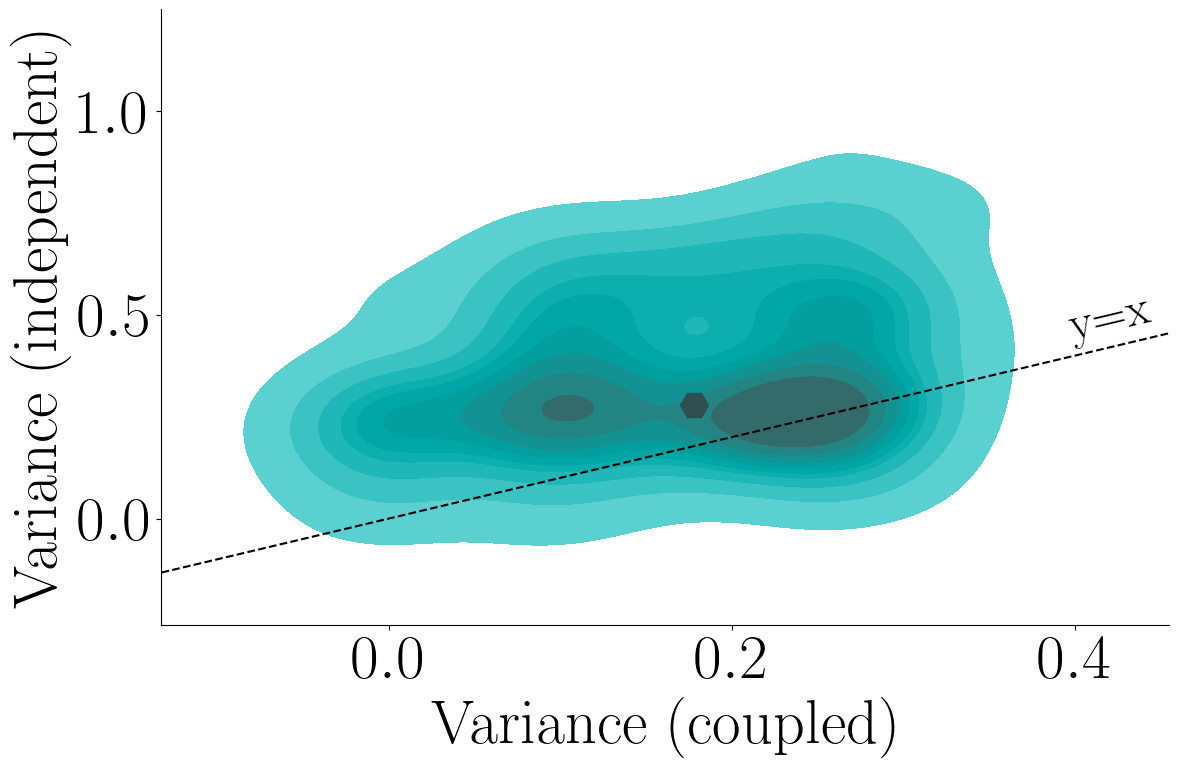

<Figure size 1300x800 with 0 Axes>

In [6]:
task = 'college_computer_science'
model_a = 'Llama-3.2-3B-Instruct'
model_b = 'Llama-3.2-1B-Instruct'
piv =  metric_per_query(task, expl_results, metric='var')
plot_var(piv, model_a, model_b, task, save=False)

In [7]:
# kde plots for several areas and all pairs of models 
tasks = [ 'college_computer_science', 'college_chemistry', 'professional_law', 'professional_accounting', 'professional_medicine']
for task in tasks:
    piv =  metric_per_query(task, expl_results, metric='var')
    for model_a in piv.columns.levels[0][:-1]:
        for model_b in piv.columns.levels[1][:-1]:
            if model_a != model_b:
                plot_var(piv, model_a, model_b, task, save=True)

<Figure size 1300x800 with 0 Axes>

## Covariance 

In [8]:
def plot_cov(task, models, expl_results, save=False):
    expl_results_task = expl_results[expl_results['Subject'] == task] 
    to_cov = expl_results_task.drop(expl_results_task.index[len(expl_results_task)//2:]).reset_index(inplace=False).drop(['Noise', 'Subject'], axis=1)
    query_id = [i  for i in range(len(to_cov)//10) for _ in range(10)]
    to_cov['Qid'] = query_id
    to_cov.set_index('Qid', inplace=True)
    # for all pairs of models
    for model_a, model_b in zip(models, models[[1,2,0]]):
        print(model_a, model_b)
        # compute the covariance matrix per model pair
        cov_matrix = to_cov[[model_a, model_b]].groupby('Qid').cov()
        # get the covariance per pair   
        cov_matrix = cov_matrix.iloc[::2][model_b].droplevel(1, axis=0).rename((model_a, model_b))
        # kde plot with fill
        ax = sns.kdeplot(cov_matrix.values, fill=True, color='teal')
        # kde plot without fill
        sns.kdeplot(cov_matrix.values, fill=False, color='teal', ax=ax)
        # get the y and x values for the mean
        x_values, y_values = ax.lines[0].get_data()
        # add vertical line for the mean
        mean = cov_matrix.mean()
        mean_y = y_values[np.abs(x_values - mean).argmin()]
        plt.vlines(mean,ymin=0, ymax=mean_y, color='teal', linestyle='--', lw=3)
        
        ax.set_xlabel("Covariance (coupled)")
        ax.set_xticks([-0.1, 0, 0.1, 0.2, 0.3])
        ax.set_yticks([0, 2, 4, 6])
        
        if save:
            fig_path = f'./figures/mmlu/{task}/covariance'
            if not os.path.exists(fig_path):
                os.makedirs(fig_path)
            plt.savefig(f"{fig_path}/cov_{model_a}_{model_b}_kde.pdf", bbox_inches='tight')
        else: 
            plt.show()
        plt.clf()

Llama-3.1-8B-Instruct Llama-3.2-3B-Instruct


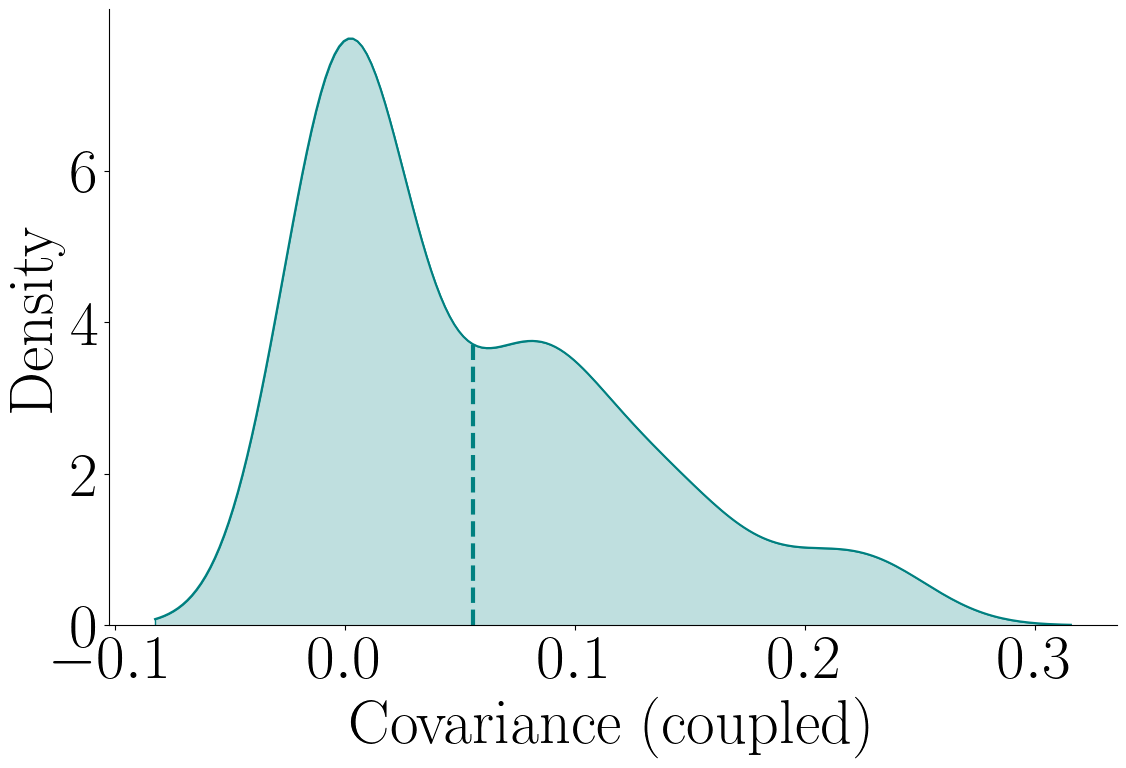

Llama-3.2-3B-Instruct Llama-3.2-1B-Instruct


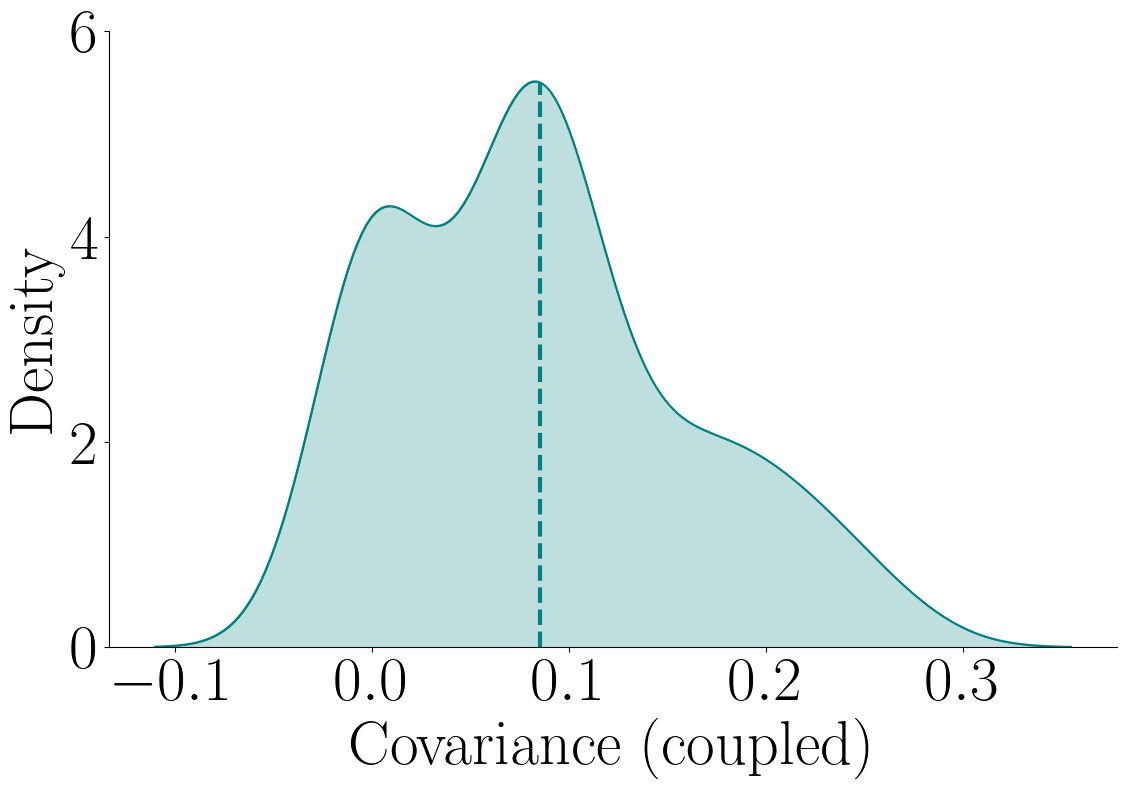

Llama-3.2-1B-Instruct Llama-3.1-8B-Instruct


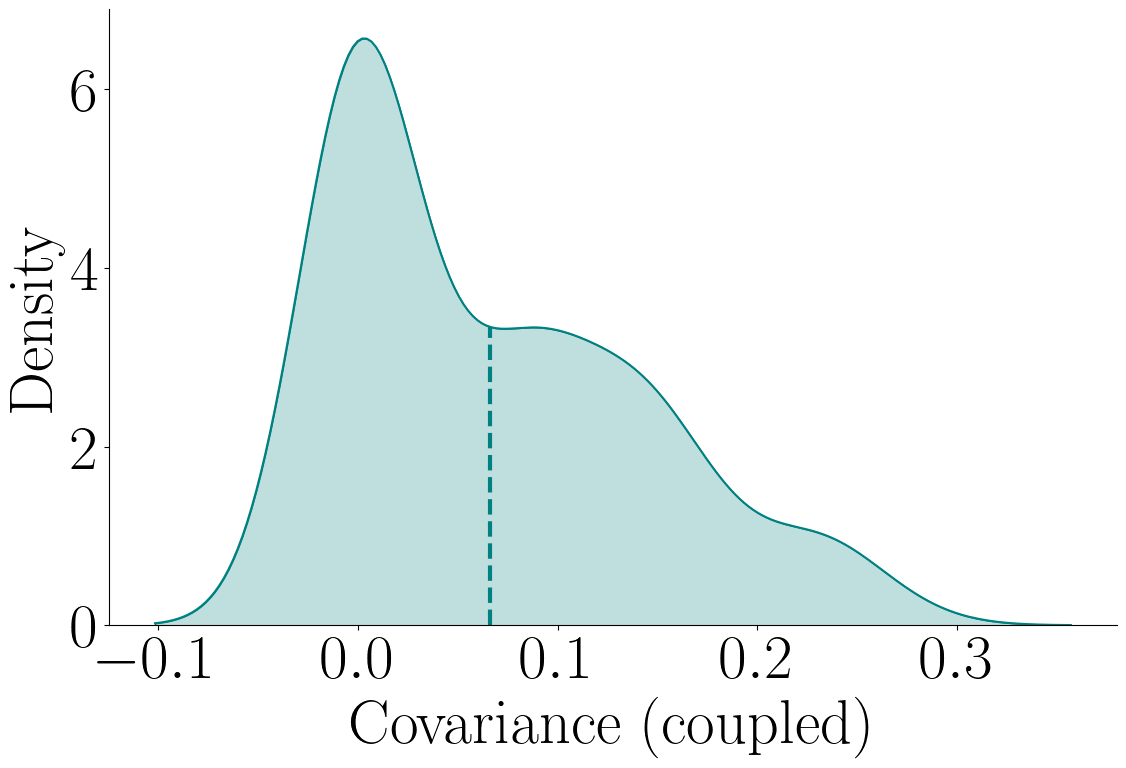

<Figure size 1300x800 with 0 Axes>

In [9]:
models = expl_results.columns[:-1].values # model names
task = 'college_computer_science'
plot_cov(task, models, expl_results, save=False)

In [ ]:
# covariance kde plots for all areas and all pairs of models
models = expl_results.columns[:-1].values
for task in subjects.unique():
    plot_cov(task, models, expl_results, save=True)

## Estimation error vs # samples

In [11]:
def plot_error(pair, pair_df, x1, x2, err, n_samples_coupled, n_samples_ind, y2=0.05, xlog=False, save=False):

    # rename the column to be the pair
    col_name = f"Estimation Error"
    pair_df.columns = [col_name]

    # create custom palette
    palette = sns.color_palette(['teal', 'palevioletred'], 2)
    sns.set_palette(palette)

    ax = sns.lineplot(pair_df, x='Samples', y=col_name, markers=True, style='Noise', hue='Noise', errorbar=('ci',95))

    # set the marker edgecolor to be the same as the facecolor
    for line in ax.get_lines():
        line.set_markeredgewidth(0)
        line.set_markersize(8)

    ax.set_xlabel('Number of Samples')
    if xlog:
        ax.set_xscale('log')

    # place the legend on top of the plot in a single line
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
    # remove frame from legend
    ax.get_legend().get_frame().set_linewidth(0.0)
    ax.get_legend().get_frame().set_alpha(None)
    ax.set_aspect('auto')
    # create zoomed in region
    axins = ax.inset_axes([0.5, 0.6, 0.4, 0.4])
    ax_of_axins = sns.lineplot(pair_df, x='Samples', y=col_name, markers=True, style='Noise', hue='Noise', errorbar=('ci',95), ax=axins,  legend=False)
    for line in ax_of_axins.get_lines():
        line.set_markeredgewidth(0)
        line.set_markersize(8)
    ax_of_axins.set_xlabel('')
    ax_of_axins.set_ylabel('')

    y1 = 0.02
    # add vertical and horizontal lines
    ax_of_axins.axhline(y=err, color='gray', linestyle='--')
    ax_of_axins.axvline(x=n_samples_coupled, ymax=(err - y1)/(y2-y1), color='gray', linestyle='--')
    ax_of_axins.axvline(x=n_samples_ind, ymax=(err - y1)/(y2-y1), color='gray', linestyle='--')
    ax_of_axins.set_xticks([n_samples_coupled, n_samples_ind])
    ax_of_axins.set_yticks([err])
    ax_of_axins.spines[['top', 'right']].set_visible(False)

    # original subregion
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_aspect('auto')
    ax.indicate_inset_zoom(axins)

    if save:
        fig_path = f'./figures/mmlu/{task}/error/'
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        plt.savefig(f"{fig_path}/error_{pair[0]}_{pair[1]}.pdf", bbox_inches='tight')
    else:
        plt.show()
    plt.clf()


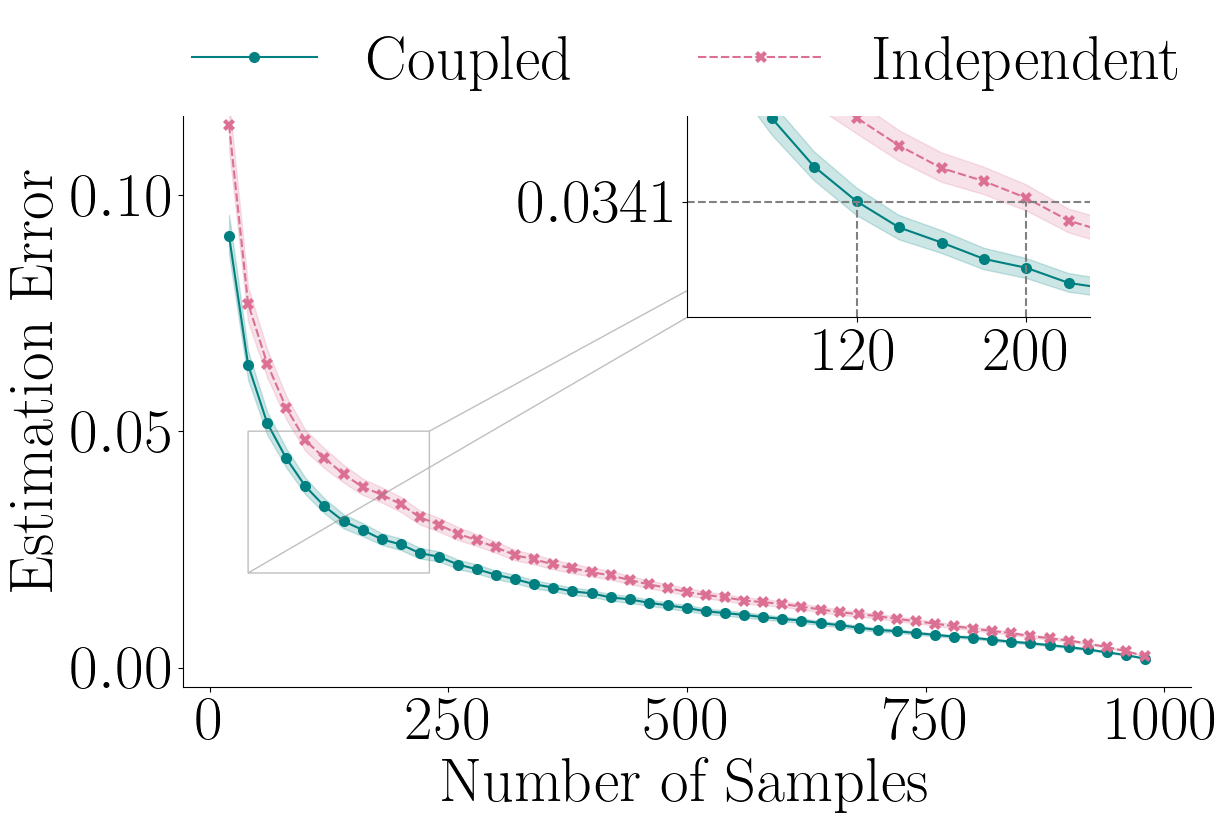

<Figure size 1300x800 with 0 Axes>

In [ ]:
task = 'college_computer_science'
error = error_vs_samples(task, expl_results)
pair = error.columns[2] # 3B and 1B
pair_df = error[pair].to_frame()

# error to draw horizontal line
err = 0.0341
# n samples for vertical lines
n_samples_coupled = 120
n_samples_ind = 200
# x-axis limits for zoomed in region
x1 = 40
x2 = 230
plot_error(pair, pair_df, x1, x2, err, n_samples_coupled, n_samples_ind, xlog=False, save=False)

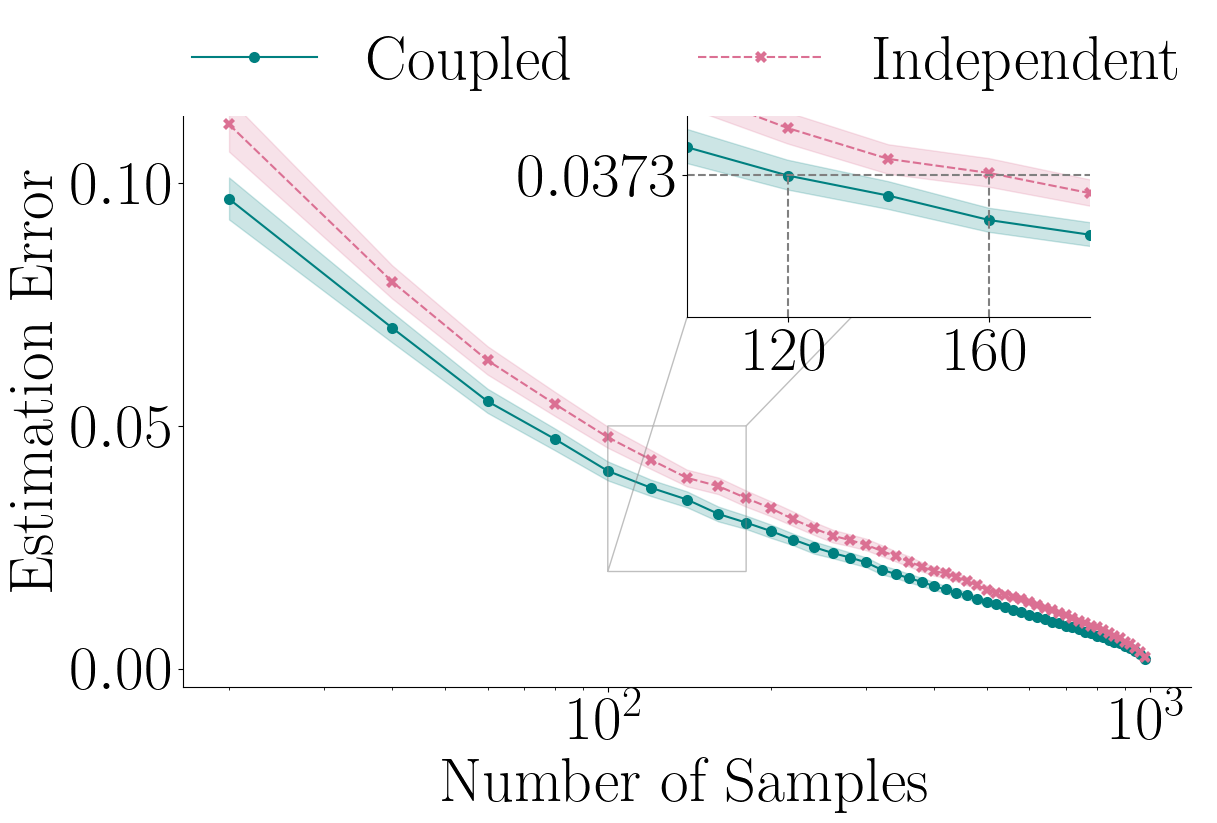

<Figure size 1300x800 with 0 Axes>

In [14]:
pair = error.columns[0] # 8B vs 3B
pair_df = error[pair].to_frame()

# error to draw horizontal line
err = 0.0373
# n samples for vertical lines
n_samples_coupled = 120
n_samples_ind = 160
# x-axis limits for zoomed in region
x1 = 100
x2 = 180
plot_error(pair, pair_df, x1, x2, err, n_samples_coupled, n_samples_ind, xlog=True, save=False)

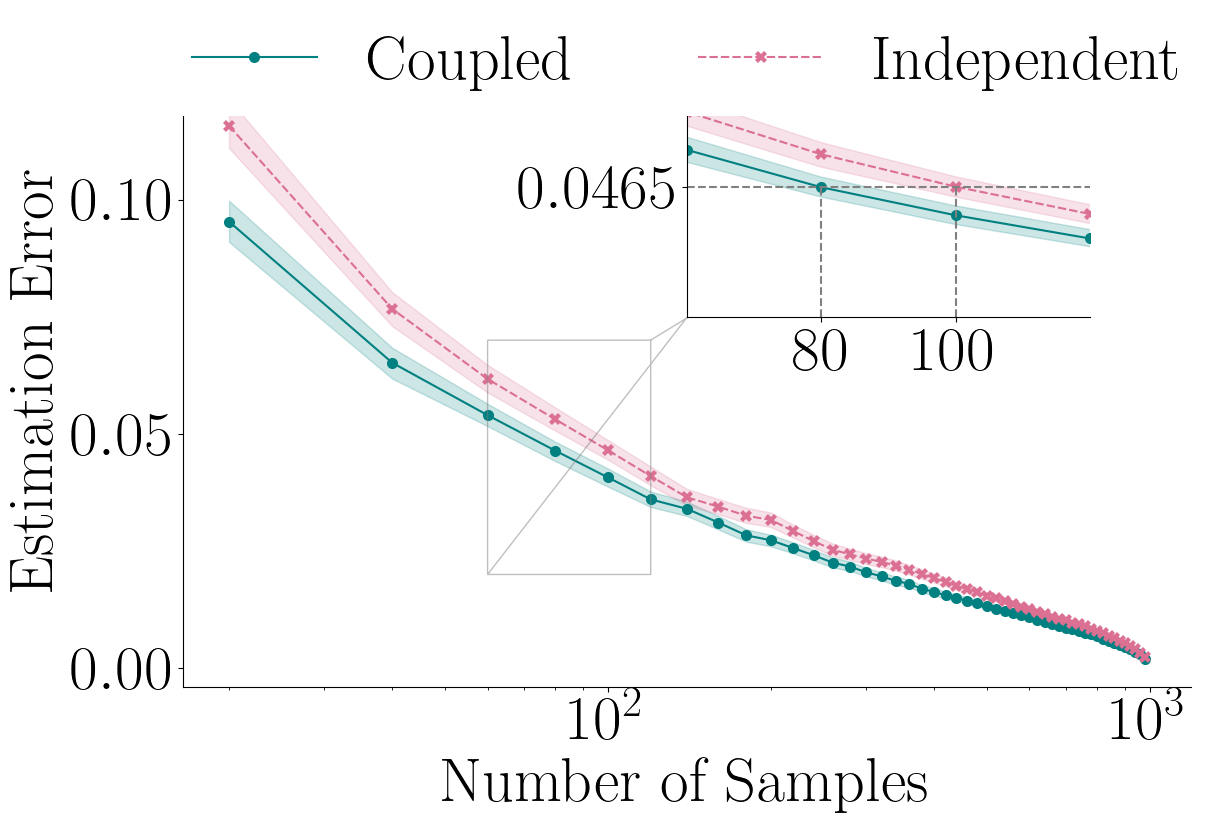

<Figure size 1300x800 with 0 Axes>

In [15]:
pair = error.columns[1] # 8B vs 1B
pair_df = error[pair].to_frame()

# error to draw horizontal line
err = 0.0465
# n samples for vertical lines
n_samples_coupled = 80
n_samples_ind = 100
# x-axis limits for zoomed in region
x1 = 60
x2 = 120
plot_error(pair, pair_df, x1, x2, err, n_samples_coupled, n_samples_ind, y2=0.07, xlog=True, save=False)

In [ ]:
err_plot_params = {
    'college_chemistry': {
        'error': 0.0315,
        'n_samples_coupled': 120,
        'n_samples_ind': 200,
        'x1': 100,
        'x2': 240
    },
    'professional_accounting': {
        'error': 0.0374,
        'n_samples_coupled': 100,
        'n_samples_ind': 180,
        'x1': 80,
        'x2': 200
    },
    'professional_law': {
        'error': 0.00341,
        'n_samples_coupled': 140,
        'n_samples_ind': 240,
        'x1': 120,
        'x2': 260
    },
    'professional_medicine': {
        'error': 0.0335,
        'n_samples_coupled': 160,
        'n_samples_ind': 240,
        'x1': 140,
        'x2': 260
    }
}
# plot error vs samples for other areas for 1B vs 3B models
for task in err_plot_params.keys():
    error = error_vs_samples(task, expl_results)
    
    pair = error.columns[2] # 3B vs 1B
    pair_df = error[pair].to_frame()
    pair_df = error[pair].to_frame()

    plot_error(pair, pair_df, err_plot_params[task]['x1'], err_plot_params[task]['x2'], err_plot_params[task]['error'], err_plot_params[task]['n_samples_coupled'], err_plot_params[task]['n_samples_ind'], xlog=True, save=True)